In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "human"
ST_name = "melanoma5fold"
seed = 10
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
pd.DataFrame(spa_adata.obsm['spatial'], index=spa_adata.obs_names, columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)
spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
rna_adata = sc.read_h5ad("../../data/scRNAseq/melanoma/Tirosh_raw.h5ad")
rna_adata = rna_adata[:, (rna_adata.var_names.values != 'MARCH1') & (rna_adata.var_names.values != 'MARCH2')].copy()

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=4)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
sc.pp.filter_genes(rna_adata, min_cells=10)
# sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].I >= 0].values:
    spa_genes.add(gene)
    
print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

In [ ]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 7633), (4645, 21118), (7340,))

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=1,
        n_epochs=2500,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2500,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                n_epochs=2500,
                clip_max=1,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2500,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "164894613", top_k=500, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )


===== Fold 1 =====
Number of train genes: 5872, Number of test genes: 1468


[TransImp] Epoch: 2500/2500, loss: 0.908068, (IMP) 0.905628, (SPA) 1.0 x 0.002440: 100%|██████████| 2500/2500 [00:14<00:00, 170.30it/s]


Median correlation: 0.19964400330351698 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.891171, (IMP) 0.891171, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 440.19it/s]


Median correlation: 0.230307958500853 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.894009, (IMP) 0.894009, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:10<00:00, 230.60it/s]


Median correlation: 0.23837980153232763 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.903217, (IMP) 0.899023, (SPA) 1.0 x 0.004194: 100%|██████████| 2500/2500 [00:08<00:00, 300.17it/s]


Median correlation: 0.19499252869866446 (TransImpClsSpa)
			0.13435225125240516 (stPlus)
			0.20206454840317462 (spaGE)


INFO:root:5872 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5872 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5872 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.373, KL reg: 0.076
Score: 0.428, KL reg: 0.000
Score: 0.429, KL reg: 0.000
Score: 0.429, KL reg: 0.000
Score: 0.429, KL reg: 0.000
Score: 0.430, KL reg: 0.000
Score: 0.430, KL reg: 0.000
Score: 0.430, KL reg: 0.000
Score: 0.430, KL reg: 0.000


INFO:root:Saving results..


Score: 0.430, KL reg: 0.000
			0.23777808287081986 (Tangram)

===== Fold 2 =====
Number of train genes: 5872, Number of test genes: 1468


[TransImp] Epoch: 2500/2500, loss: 0.903939, (IMP) 0.901439, (SPA) 1.0 x 0.002500: 100%|██████████| 2500/2500 [00:13<00:00, 182.70it/s]


Median correlation: 0.20494423661554204 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.888501, (IMP) 0.888501, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 464.08it/s]


Median correlation: 0.2346894597938231 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.890803, (IMP) 0.890803, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:10<00:00, 230.75it/s]


Median correlation: 0.23920383257801248 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.900734, (IMP) 0.896395, (SPA) 1.0 x 0.004339: 100%|██████████| 2500/2500 [00:08<00:00, 300.26it/s]


Median correlation: 0.20420225965400945 (TransImpClsSpa)
			0.18489264188343735 (stPlus)
			0.20076132967968022 (spaGE)


INFO:root:5872 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5872 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5872 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.375, KL reg: 0.076
Score: 0.431, KL reg: 0.000
Score: 0.432, KL reg: 0.000
Score: 0.432, KL reg: 0.000
Score: 0.432, KL reg: 0.000
Score: 0.432, KL reg: 0.000
Score: 0.432, KL reg: 0.000
Score: 0.432, KL reg: 0.000
Score: 0.432, KL reg: 0.000


INFO:root:Saving results..


Score: 0.432, KL reg: 0.000
			0.23874919934845898 (Tangram)

===== Fold 3 =====
Number of train genes: 5872, Number of test genes: 1468


[TransImp] Epoch: 2500/2500, loss: 0.898660, (IMP) 0.896252, (SPA) 1.0 x 0.002408: 100%|██████████| 2500/2500 [00:14<00:00, 176.58it/s]


Median correlation: 0.19856003324772076 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.882705, (IMP) 0.882705, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 462.03it/s]


Median correlation: 0.22827724710629516 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.884825, (IMP) 0.884825, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:10<00:00, 232.56it/s]


Median correlation: 0.2318794937309966 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.894916, (IMP) 0.890591, (SPA) 1.0 x 0.004326: 100%|██████████| 2500/2500 [00:08<00:00, 292.61it/s]


Median correlation: 0.19940843542258246 (TransImpClsSpa)
			nan (stPlus)
			0.19904874448325022 (spaGE)


INFO:root:5872 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5872 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5872 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.376, KL reg: 0.076
Score: 0.433, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000


INFO:root:Saving results..


Score: 0.434, KL reg: 0.000
			0.23474314430148308 (Tangram)

===== Fold 4 =====
Number of train genes: 5872, Number of test genes: 1468


[TransImp] Epoch: 2500/2500, loss: 0.903425, (IMP) 0.901053, (SPA) 1.0 x 0.002372: 100%|██████████| 2500/2500 [00:13<00:00, 181.22it/s]


Median correlation: 0.1987213013753379 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.888153, (IMP) 0.888153, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 460.52it/s]


Median correlation: 0.22635022111959135 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.890322, (IMP) 0.890322, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:10<00:00, 233.33it/s]


Median correlation: 0.2259849386883649 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.900282, (IMP) 0.896109, (SPA) 1.0 x 0.004174: 100%|██████████| 2500/2500 [00:08<00:00, 301.73it/s]


Median correlation: 0.19893610258638683 (TransImpClsSpa)
			0.05929403586054395 (stPlus)
			0.1975388111101067 (spaGE)


INFO:root:5872 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5872 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5872 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.377, KL reg: 0.077
Score: 0.433, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000
Score: 0.434, KL reg: 0.000


INFO:root:Saving results..


Score: 0.434, KL reg: 0.000
			0.23299865519601776 (Tangram)

===== Fold 5 =====
Number of train genes: 5872, Number of test genes: 1468


[TransImp] Epoch: 2500/2500, loss: 0.897960, (IMP) 0.895414, (SPA) 1.0 x 0.002546: 100%|██████████| 2500/2500 [00:13<00:00, 181.24it/s]


Median correlation: 0.20243843625385854 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.882001, (IMP) 0.882001, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 458.72it/s]


Median correlation: 0.2334103420217758 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.884311, (IMP) 0.884311, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:10<00:00, 237.87it/s]


Median correlation: 0.23621888445435735 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.893991, (IMP) 0.889630, (SPA) 1.0 x 0.004361: 100%|██████████| 2500/2500 [00:08<00:00, 304.99it/s]


Median correlation: 0.2029964467267706 (TransImpClsSpa)
			0.16529696876000455 (stPlus)
			0.19838147327323896 (spaGE)


INFO:root:5872 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5872 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5872 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.377, KL reg: 0.076
Score: 0.432, KL reg: 0.000
Score: 0.433, KL reg: 0.000
Score: 0.433, KL reg: 0.000
Score: 0.433, KL reg: 0.000
Score: 0.433, KL reg: 0.000
Score: 0.433, KL reg: 0.000
Score: 0.433, KL reg: 0.000
Score: 0.433, KL reg: 0.000


INFO:root:Saving results..


Score: 0.433, KL reg: 0.000
			0.2360134323473097 (Tangram)
0.20073073498687083 (TransImpSpa) 0.23443113649305247 (TransImp) 0.2307685975297477 (TransImpCls) 0.20014488829374394 (TransImpClsSpa) nan (stPlus) 0.19943804445307398 (spaGE) 0.23589903320538302 (Tangram)


In [ ]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [ ]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
# spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [ ]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.287555
	True vs TransImpSpa: 0.005507
	True vs TransImpCls: 0.303556
	True vs TransImpClsSpa: 0.004997
	True vs spaGE: 0.198600
	True vs Tangram: 0.277857
	True vs truth: 0.000000


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [ ]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=4)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

  0%|          | 0/8 [00:00<?, ?it/s]

truth


 12%|█▎        | 1/8 [00:02<00:20,  2.97s/it]

stPlus


 25%|██▌       | 2/8 [00:06<00:19,  3.19s/it]

spaGE


 38%|███▊      | 3/8 [00:09<00:15,  3.14s/it]

Tangram


 50%|█████     | 4/8 [00:12<00:12,  3.22s/it]

TransImp


 62%|██████▎   | 5/8 [00:15<00:09,  3.17s/it]

TransImpSpa


 75%|███████▌  | 6/8 [00:19<00:06,  3.25s/it]

TransImpCls


 88%|████████▊ | 7/8 [00:22<00:03,  3.20s/it]

TransImpClsSpa


100%|██████████| 8/8 [00:25<00:00,  3.18s/it]


In [ ]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
A1BG,0.000000,0.000000,0.000000,0.004236,0.000000e+00,0.000000,NaN,4.137509e-01
A2M,0.000000,0.000000,0.000000,0.004236,7.056659e-09,0.000000,NaN,1.466422e-08
AAAS,0.000000,0.000000,0.000000,0.004236,1.048211e-08,0.000000,NaN,5.900651e-02
AACS,0.000000,0.000000,0.000000,0.004580,3.830699e-08,0.000000,NaN,3.907039e-01
AAED1,0.000000,0.000000,0.000000,0.005061,1.336823e-07,0.000000,NaN,4.468257e-01
...,...,...,...,...,...,...,...,...
ZSCAN18,0.221595,0.038626,0.075737,0.211464,1.136594e-02,0.277203,NaN,3.393438e-01
ZSCAN26,0.238547,0.071948,0.092869,0.166012,1.091985e-02,0.204434,NaN,9.152791e-02
ZSCAN29,0.281521,0.072184,0.106333,0.143757,9.279272e-03,0.204264,NaN,2.318493e-01
ZWINT,0.453532,0.287401,0.397772,0.121511,8.307996e-03,0.141136,NaN,2.328946e-01


(Tangram) Valid genes: 7059/7340
0
Tangram
(Tangram) Valid genes: 7059/7340, Ground Sig/Total (849/7059), Pred Sig/total (7034/7059)
FPR: 0.996135
(TransImp) Valid genes: 7059/7340
0
TransImp
(TransImp) Valid genes: 7059/7340, Ground Sig/Total (849/7059), Pred Sig/total (7048/7059)
FPR: 0.998229
(TransImpSpa) Valid genes: 7059/7340
0
TransImpSpa
(TransImpSpa) Valid genes: 7059/7340, Ground Sig/Total (849/7059), Pred Sig/total (1311/7059)
FPR: 0.184541
(spaGE) Valid genes: 7059/7340
0
spaGE
(spaGE) Valid genes: 7059/7340, Ground Sig/Total (849/7059), Pred Sig/total (6883/7059)
FPR: 0.973269
(stPlus) Valid genes: 7058/7340
7058
stPlus
(stPlus) Valid genes: 7058/7340, Ground Sig/Total (849/7058), Pred Sig/total (0/7058)
FPR: 0.000000


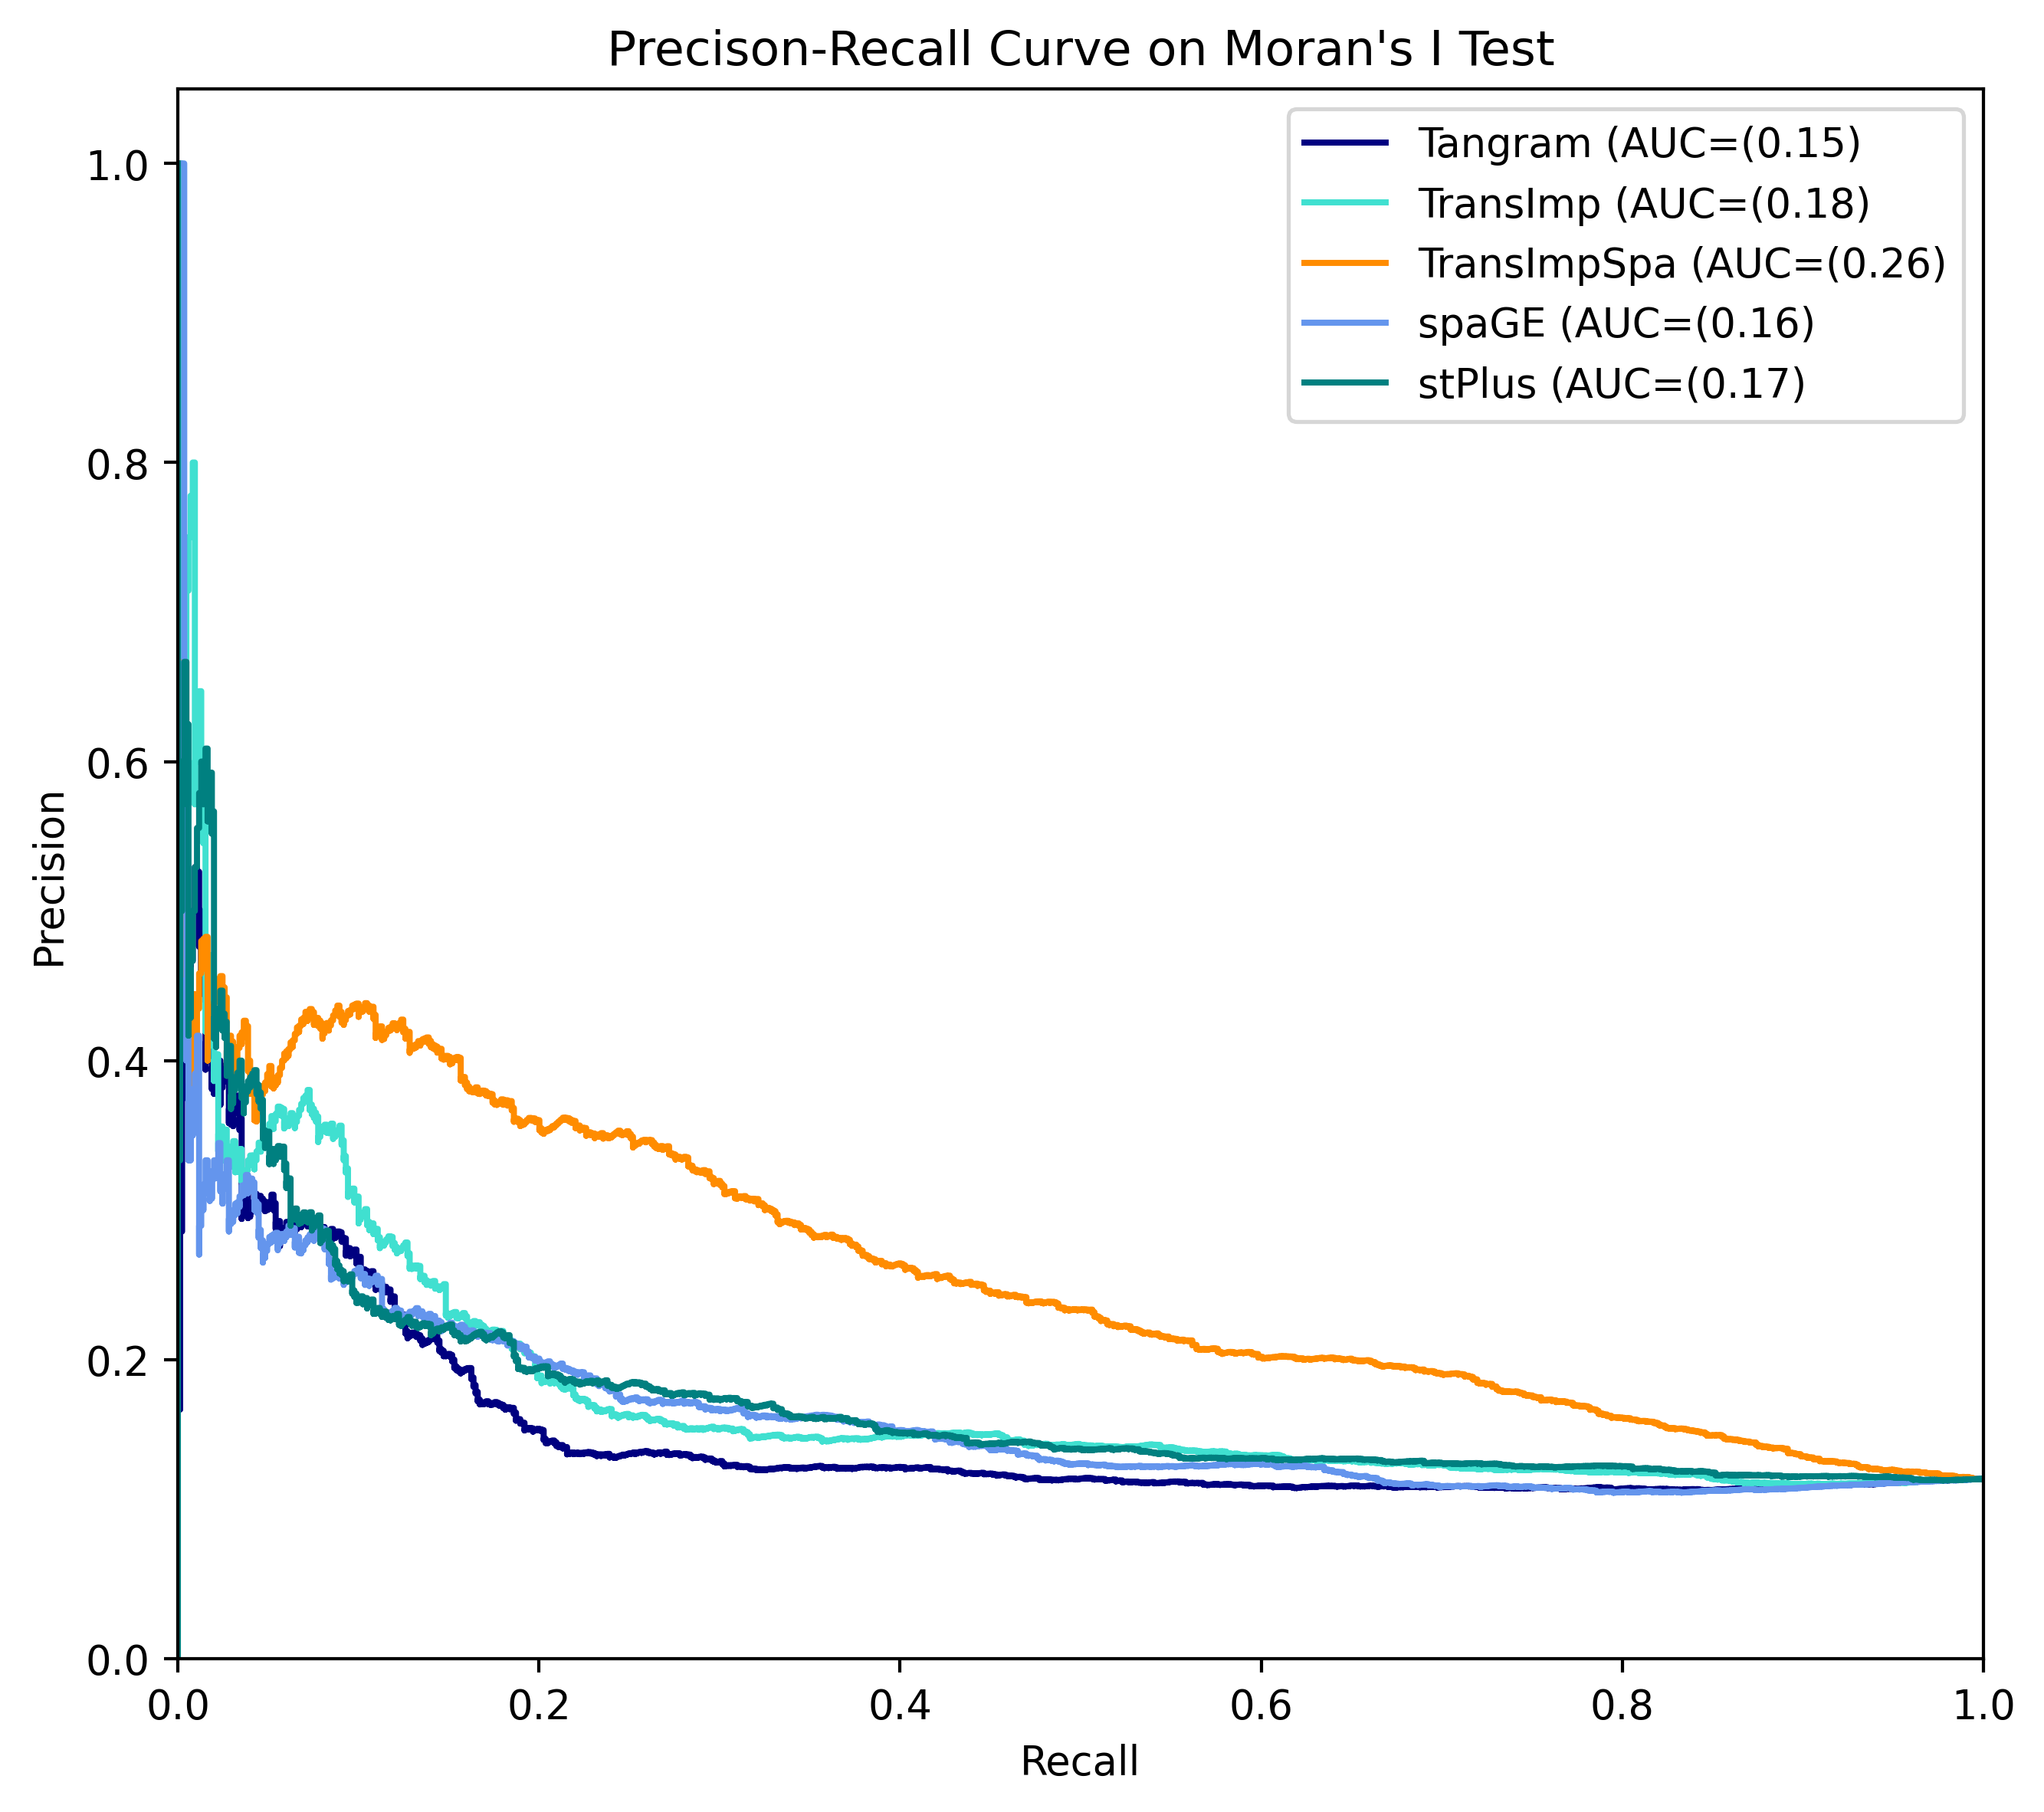

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, fdr = df_fdr.truth.values[sel], df_fdr[method][sel]
    I = df_I[method][sel]
    print(np.isnan(fdr).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = fdr < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(y < thred).sum()}/{y.shape[0]}), Pred Sig/total ({(fdr < thred).sum()}/{fdr.shape[0]})')
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(y < thred, I):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 7059/7340
Tangram
FPR: 0.996135
(TransImp) Valid genes: 7059/7340
TransImp
FPR: 0.998229
(TransImpSpa) Valid genes: 7059/7340
TransImpSpa
FPR: 0.184541
(spaGE) Valid genes: 7059/7340
spaGE
FPR: 0.973269
(stPlus) Valid genes: 7058/7340
stPlus
FPR: 0.000000


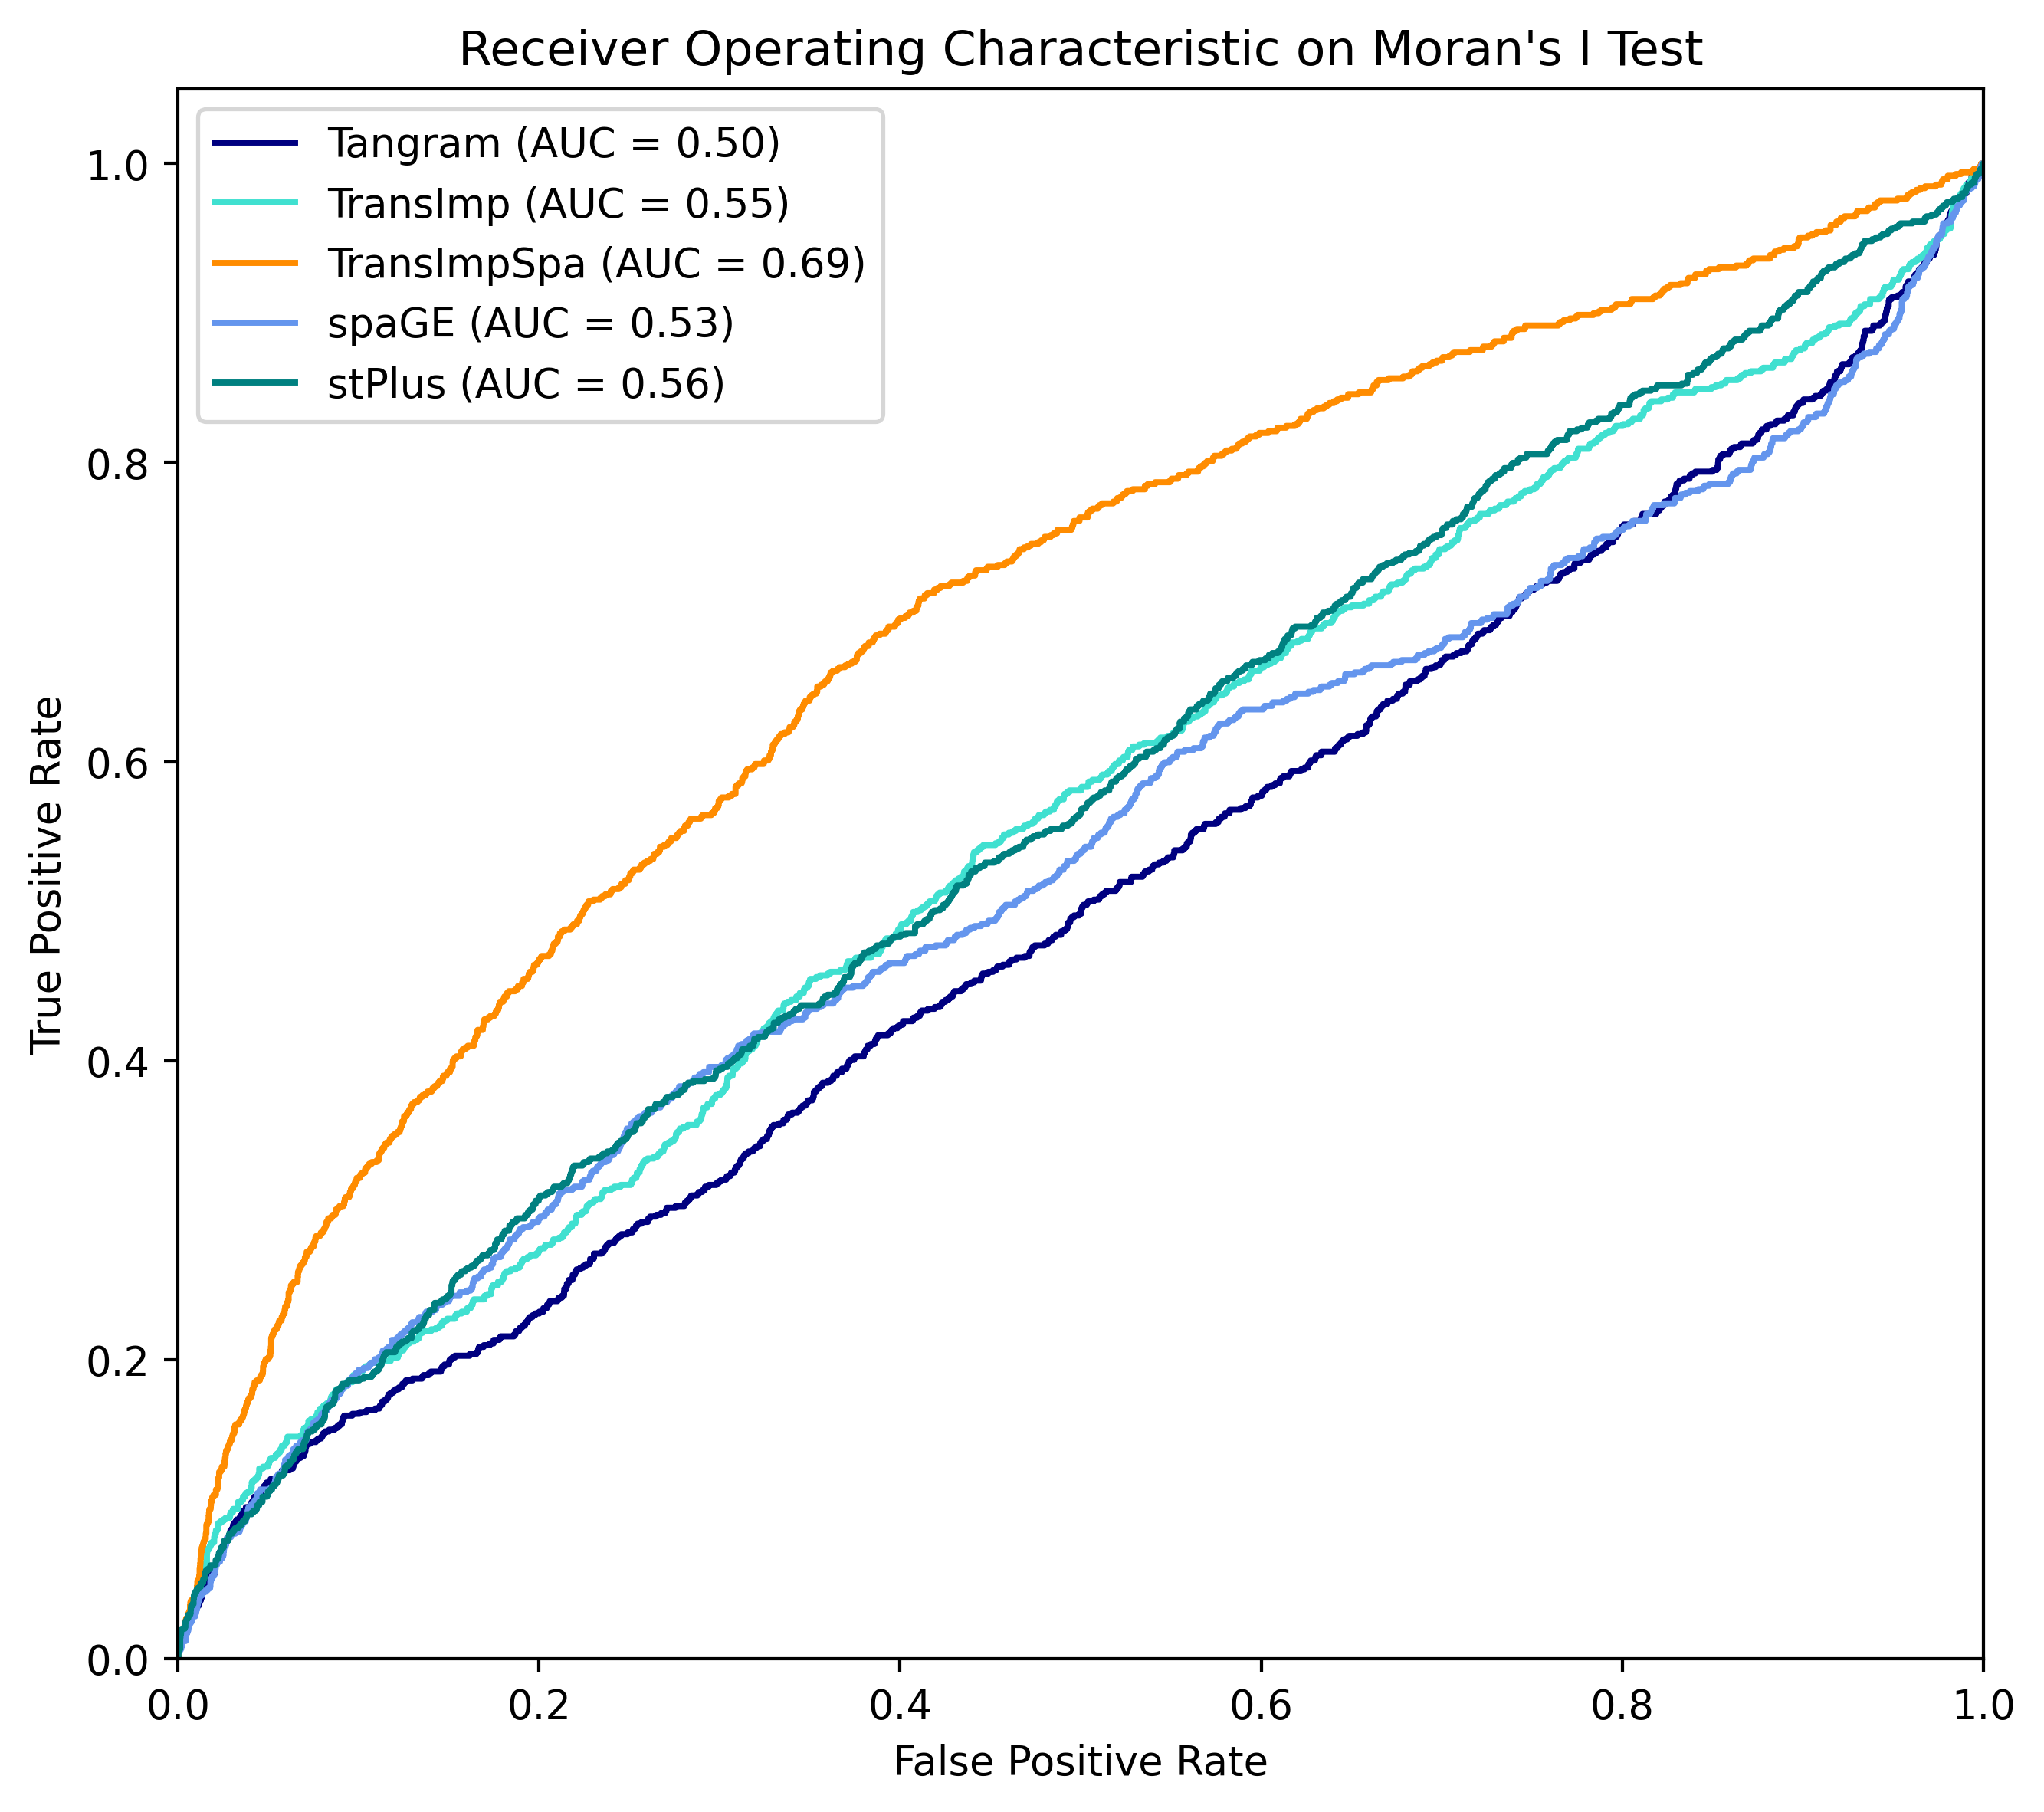

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [ ]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_fdr.truth.values[sel], df_fdr[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(y < thred, I):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(stPlus) Valid genes: 7058/7340
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(spaGE) Valid genes: 7059/7340
spaGE
FPR: 0.973269
prec: 0.12189452273717856, recl: 0.9882214369846879,  F1: 0.21702017589239528
(Tangram) Valid genes: 7059/7340
Tangram
FPR: 0.996135
prec: 0.12055729314756895, recl: 0.9988221436984688,  F1: 0.2151465178231638
(TransImp) Valid genes: 7059/7340
TransImp
FPR: 0.998229
prec: 0.12045970488081725, recl: 1.0,  F1: 0.2150183614030645
(TransImpSpa) Valid genes: 7059/7340
TransImpSpa
FPR: 0.184541
prec: 0.12585812356979406, recl: 0.19434628975265017,  F1: 0.1527777777777778
(TransImpCls) Valid genes: 7059/7340
TransImpCls
FPR: 0.998551
prec: 0.12042553191489362, recl: 1.0,  F1: 0.21496391948347893
(TransImpClsSpa) Valid genes: 7059/7340
TransImpClsSpa
FPR: 0.077295
prec: 0.1111111111111111, recl: 0.0706713780918728,  F1: 0.08639308855291576


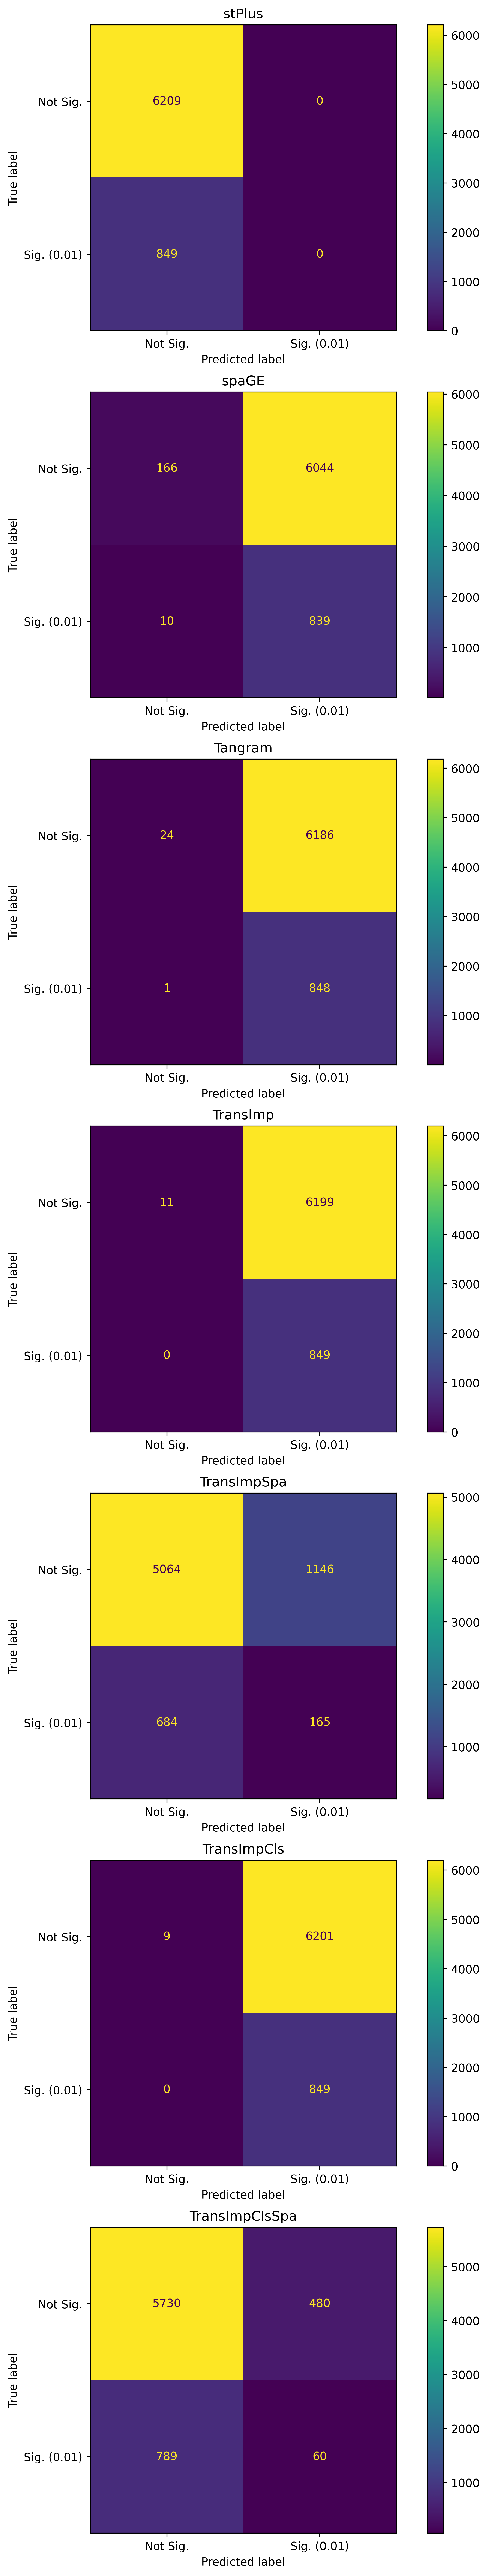

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_fdr.truth.values[sel], df_fdr[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [ ]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r melanoma5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 7340 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 7338 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With

In [ ]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
stPlus


KeyError: "['CTSG' 'NR0B1'] not in index"

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    # score = -np.log(df_sparkx_cmbpvals[method][sel].values + 1e-100)
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    score = -np.log(df_sparkx_cmbpvals[method][sel].values + 1e-100)
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [ ]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in dict_adata:
    spatialdm(dict_adata[md], "human", 1.2)    

In [ ]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(dict_adata, outfile)

In [ ]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"# {len(genes)} pairs, # sig pairs: {truth_res.loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        new_scores = list(range(len(score)))
        score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
       
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        new_scores = list(range(len(score)))
        score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(dict_adata, ST_name)
roc_curve(dict_adata, ST_name)
